<a href="https://colab.research.google.com/github/teamsimcoemmai/mmai894/blob/894-pj/Final%20Project/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# pip install tqdm

In [ ]:
import pandas as pd
from pathlib import Path
import os

import matplotlib.pyplot as plt
import random
import scipy.io as sio
import numpy as np

import cv2 as cv
from google.colab.patches import cv2_imshow
from keras.preprocessing import image
from tqdm import tqdm

In [ ]:
df_total = pd.read_csv('/content/drive/MyDrive/Simcoe/894/Car dataset/df_total.csv')
df_train = pd.read_csv('/content/drive/MyDrive/Simcoe/894/Car dataset/df_train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Simcoe/894/Car dataset/df_test.csv')
df_car_names = pd.read_csv('/content/drive/MyDrive/Simcoe/894/Car dataset/Copy of df_car_names.csv')

In [ ]:
df_train = df_train[df_train.columns.drop(list(df_train.filter(regex='Unnamed:')))]
df_test = df_test[df_test.columns.drop(list(df_test.filter(regex='Unnamed:')))]
df_total = df_total[df_total.columns.drop(list(df_total.filter(regex='Unnamed:')))]

In [ ]:
df_total1 = df_total.merge(df_car_names, left_on='class', right_on='Unnamed: 0')
df_total1

,img_path,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,test,test_new,Unnamed: 0,car_class_name,car_class_name.1
0,car_ims/000001.jpg,112,7,853,717,1,0,0,1,AM General Hummer SUV 2000,AM General Hummer SUV
1,car_ims/000002.jpg,48,24,441,202,1,0,0,1,AM General Hummer SUV 2000,AM General Hummer SUV
2,car_ims/000003.jpg,7,4,277,180,1,0,0,1,AM General Hummer SUV 2000,AM General Hummer SUV
3,car_ims/000004.jpg,33,50,197,150,1,0,1,1,AM General Hummer SUV 2000,AM General Hummer SUV
4,car_ims/000005.jpg,5,8,83,58,1,0,0,1,AM General Hummer SUV 2000,AM General Hummer SUV
...,...,...,...,...,...,...,...,...,...,...,...
16180,car_ims/016181.jpg,38,36,375,234,196,1,0,196,smart fortwo Convertible 2012,smart fortwo Convertible
16181,car_ims/016182.jpg,29,34,235,164,196,1,0,196,smart fortwo Convertible 2012,smart fortwo Convertible
16182,car_ims/016183.jpg,25,32,587,359,196,1,0,196,smart fortwo Convertible 2012,smart fortwo Convertible
16183,car_ims/016184.jpg,56,60,208,186,196,1,0,196,smart fortwo Convertible 2012,smart fortwo Convertible


In [ ]:
columns = ['img_path','bbox_x1','bbox_y1','bbox_x2','bbox_y2','class','test','car_class_name','test_new']
df_total1 = df_total1.filter(columns)

In [ ]:
df_total1['car_class_name'].value_counts()

GMC Savana Van 2012                                    136
Chrysler 300 SRT-8 2010                                 97
Mercedes-Benz 300-Class Convertible 1993                96
Mitsubishi Lancer Sedan 2012                            95
Jaguar XK XKR 2012                                      93
                                                      ... 
Rolls-Royce Phantom Drophead Coupe Convertible 2012     61
Chevrolet Express Cargo Van 2007                        59
Maybach Landaulet Convertible 2012                      58
FIAT 500 Abarth 2012                                    55
Hyundai Accent Sedan 2012                               48
Name: car_class_name, Length: 196, dtype: int64

In [ ]:
# check if there are any null vales for car class
df_total1[df_total1['car_class_name'].isnull()]

,img_path,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,test,car_class_name,test_new


In [ ]:
#calculate bonding box hight and width
df_total1['bbox_h'] = df_total1['bbox_y2'] - df_total1['bbox_y1']
df_total1['bbox_w'] = df_total1['bbox_x2'] - df_total1['bbox_x1'] 

# split image name from image path
df_total1[['folder','img_name']] = df_total1['img_path'].str.split('/', 1, expand=True)
df_total1 = df_total1.drop(columns=['folder'])

In [ ]:
df_total1

,img_path,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,test,car_class_name,test_new,bbox_h,bbox_w,img_name
0,car_ims/000001.jpg,112,7,853,717,1,0,AM General Hummer SUV 2000,0,710,741,000001.jpg
1,car_ims/000002.jpg,48,24,441,202,1,0,AM General Hummer SUV 2000,0,178,393,000002.jpg
2,car_ims/000003.jpg,7,4,277,180,1,0,AM General Hummer SUV 2000,0,176,270,000003.jpg
3,car_ims/000004.jpg,33,50,197,150,1,0,AM General Hummer SUV 2000,1,100,164,000004.jpg
4,car_ims/000005.jpg,5,8,83,58,1,0,AM General Hummer SUV 2000,0,50,78,000005.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...
16180,car_ims/016181.jpg,38,36,375,234,196,1,smart fortwo Convertible 2012,0,198,337,016181.jpg
16181,car_ims/016182.jpg,29,34,235,164,196,1,smart fortwo Convertible 2012,0,130,206,016182.jpg
16182,car_ims/016183.jpg,25,32,587,359,196,1,smart fortwo Convertible 2012,0,327,562,016183.jpg
16183,car_ims/016184.jpg,56,60,208,186,196,1,smart fortwo Convertible 2012,0,126,152,016184.jpg


In [ ]:
def show_img(folder_path,idx):
  im = plt.imread(folder_path+df_total1.img_name[idx])
  x_min = df_total1.bbox_x1[idx]
  y_min = df_total1.bbox_y1[idx]
  x_max = df_total1.bbox_x2[idx]
  y_max = df_total1.bbox_y2[idx]
  image1 = cv2.rectangle(im,(x_min,y_min),(x_max,y_max),(0,255,0),2)
  plt.imshow(image1)
    
def plot_text(idx):
  text = df_total1.car_class_name[idx]
  x_min = df_total1.bbox_x1[idx]
  y_min = df_total1.bbox_y1[idx]
  x_max = df_total1.bbox_x2[idx]
  y_max = df_total1.bbox_y2[idx]
  plt.text(x_min, y_min, text, fontsize=15, color='black')

def crop(df, path, i):
    image = plt.imread(path + df.img_name[i])
    x1 = df['bbox_x1'][i]
    y1 = df['bbox_y1'][i]
    h = df['bbox_h'][i]
    w = df['bbox_w'][i]
    
    if len(image.shape) == 3:
        return image[y1:y1+h+16 , x1:x1+w+16, :]
    else:
        # If there are only 2 channels for the image
        return image[y1:y1+h+16 , x1:x1+w+16]

In [ ]:
car_img_path = '/content/drive/MyDrive/894 proj/car_ims/'
idx = 0

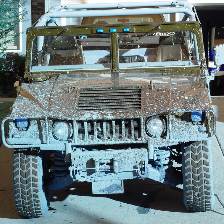

In [ ]:
#show an example of cropped car
crop_img = crop(df_total1,car_img_path, idx)
dst_img = cv.resize(src=crop_img, dsize=(224, 224))
cv2_imshow(dst_img)

In [ ]:
## Save cropped image to 'cropped_raw' folder, please do not run since the cropped images already exists. Demonstration purpose only
# for idx in tqdm(range(df_total1)):
#   crop_img = crop(df_total1,car_img_path, idx)
#   dst_img = cv.resize(src=crop_img, dsize=(224, 224))
#   cv.imwrite('/content/drive/MyDrive/Simcoe/894/Car dataset/cropped_raw/{}'.format(df_total1['img_name'][idx]), dst_img)

In [ ]:
# define train, validation and test set in to 70% train, 15% validation and 15% test
img_height, img_width = 224, 224
margin = 16

src_folder = '/content/drive/MyDrive/Simcoe/894/Car dataset/cropped_raw'

num_samples = len(df_total1)

train_split = 0.7
val_split = 0.15
num_train = int(round(num_samples * train_split))
num_val = int(round(num_samples * val_split))
train_indexes = random.sample(range(num_samples), num_train)

total_index = df_total1.index.tolist()
exclue_train_index = np.setdiff1d(total_index,train_indexes)
val_indexes = random.sample(list(exclue_train_index), num_val)

fnames = df_total1['img_name'].values.tolist()
labels = df_total1['class'].values.tolist()

# split image to train,validation and test folders
for i in range(num_samples):
    fname = fnames[i]
    label = labels[i]

    src_path = os.path.join(src_folder, fname)
    src_image = cv.imread(src_path)
    
    if i in val_indexes:
        dst_folder = '/content/drive/MyDrive/Simcoe/894/Car dataset/new/val_set'        
    elif i in train_indexes:
        dst_folder = '/content/drive/MyDrive/Simcoe/894/Car dataset/new/train_set'
    else:
        dst_folder = '/content/drive/MyDrive/Simcoe/894/Car dataset/new/test_set'

    
    print("Src:" + src_path)
    
    print("Label:" + str(label))
    
    dst_path = os.path.join(dst_folder, str(label))
    print("Dst:" + dst_path)
    if not os.path.exists(dst_path):
        os.makedirs(dst_path)
    dst_path = os.path.join(dst_path, fname)

    dst_img = cv.resize(src=src_image, dsize=(img_height, img_width))
    cv.imwrite(dst_path, dst_img)